In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import tensor, num, qeye, create, destroy, basis, sesolve, expect, mesolve
from compute_g0 import compute_g0, compute_g0_2nd_approx
from compute_fidelity import compute_fidelity
from tqdm import tqdm

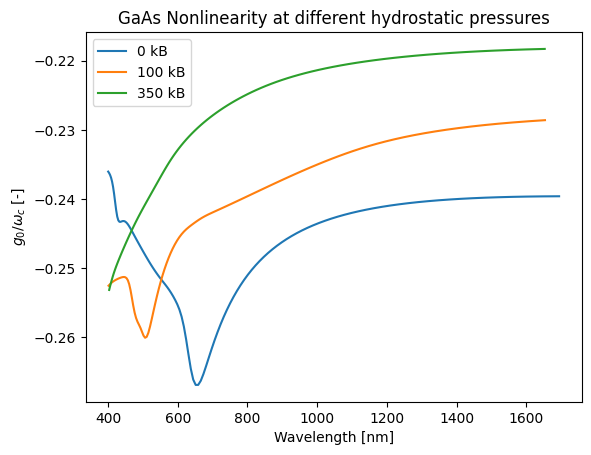

In [18]:
omega1, g_0_array_p1 = compute_g0(outcar_name="PSTRESS/OUTCAR_0", 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= 2*1e-5, semiconductor_length= 1e-5)
omega2, g_0_array_p2 = compute_g0(outcar_name="PSTRESS/OUTCAR_100", 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= 2*1e-5, semiconductor_length= 1e-5)
omega3, g_0_array_p3 = compute_g0(outcar_name="PSTRESS/OUTCAR_350", 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= 2*1e-5, semiconductor_length= 1e-5)

plt.plot(2*np.pi*3*10**17/omega1, g_0_array_p1/omega1, label='0 kB')
plt.plot(2*np.pi*3*10**17/omega2, g_0_array_p2/omega2, label='100 kB')
plt.plot(2*np.pi*3*10**17/omega3, g_0_array_p3/omega3, label='350 kB')

plt.xlabel('Wavelength [nm]')
plt.ylabel(r'$g_0/\omega_c$ [-]')
plt.title('GaAs Nonlinearity at different hydrostatic pressures')
plt.legend()
plt.show()

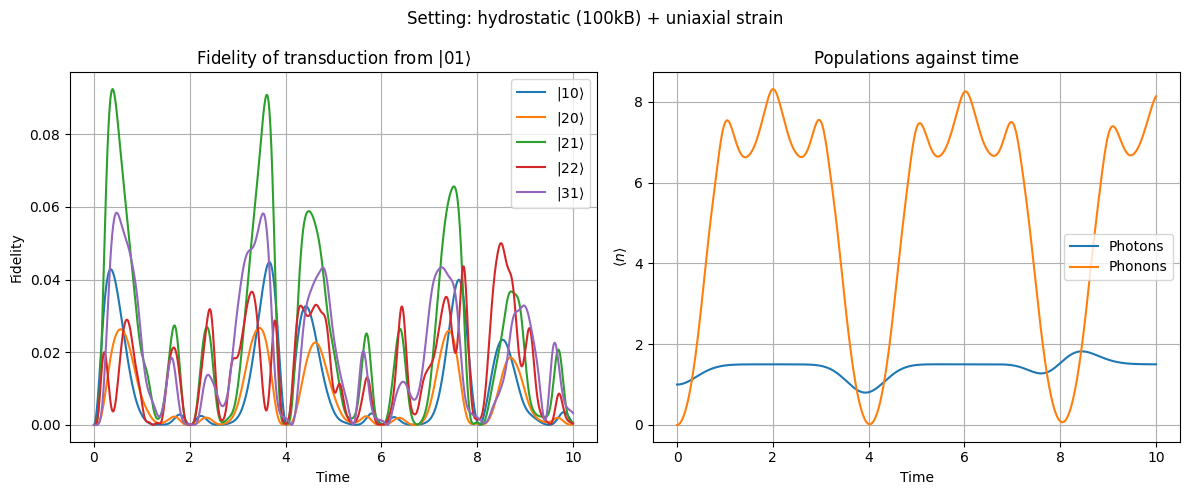

In [ ]:
wavelength_photon = 1.55*10**-6
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega_phonon = 2*np.pi*10**13
alpha = 0.5

omega2, g_0_array_p2 = compute_g0_2nd_approx(outcar_name="PSTRESS/OUTCAR_100", 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= 2*1e-5, semiconductor_length= 1e-5, gradient_value=gradients[wavelength_photon])
# omega2, g_0_array_p2 = compute_g0(outcar_name="PSTRESS/OUTCAR_100", 
#         plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
#         cavity_length= 2*1e-5, semiconductor_length= 1e-5)
omega_photon = 2*np.pi*3*10**8/wavelength_photon
max_fidelities, results = compute_fidelity(omega2, g_0_array_p2, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time= 10, 
                 plot_text = 'Setting: hydrostatic (100kB) + uniaxial strain', 
                 plot = True, set_g_0 = None)



### Fidelity againt semiconductor length

Progress: 100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


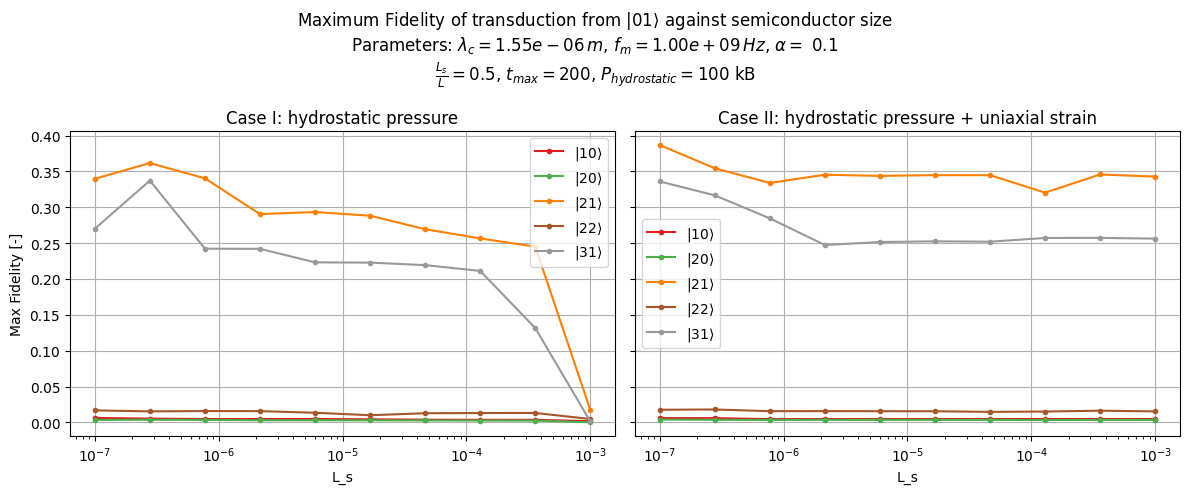

In [17]:
alpha = 0.1
wavelength_photon = 1.55*1e-6 # m
frequency_phonon = 1e9 # Hz
tmax = 200

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega_phonon = 2*np.pi*frequency_phonon
cavity_semiconductor_length_factor = 2
omega_photon = 2*np.pi*3*10**8/wavelength_photon
expected_keys = ['10', '20', '21', '22', '31']
fidelity_dict_1st = {key: [] for key in expected_keys}
fidelity_dict_2nd = {key: [] for key in expected_keys}

lengths = np.logspace(-7, -3, 10)
for semiconductor_length in tqdm(lengths,total=len(lengths), desc='Progress'):
    omega_array, g_0_array_1st = compute_g0(outcar_name='PSTRESS/OUTCAR_100', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_semiconductor_length_factor*semiconductor_length, semiconductor_length= semiconductor_length)
    
    omega_array, g_0_array_2nd = compute_g0_2nd_approx(outcar_name='PSTRESS/OUTCAR_100', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_semiconductor_length_factor*semiconductor_length, semiconductor_length= semiconductor_length, 
        gradient_value=gradients[wavelength_photon])
    
    max_fidelities_1st, _ = compute_fidelity(omega_array, g_0_array_1st, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)
    
    max_fidelities_2nd, _ = compute_fidelity(omega_array, g_0_array_2nd, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)

    for key, value in max_fidelities_1st.items():
        fidelity_dict_1st[key].append(value)

    
    for key, value in max_fidelities_2nd.items():
        fidelity_dict_2nd[key].append(value)

# Assign a unique color to each key using a colormap
colors = plt.cm.Set1(np.linspace(0, 1, len(expected_keys)))  
color_map = {key: color for key, color in zip(expected_keys, colors)}
fig, ax = plt.subplots(1, 2, figsize=(12,5),sharey=True)
for key in expected_keys:
    ax[0].plot(lengths, fidelity_dict_1st[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])
    ax[1].plot(lengths, fidelity_dict_2nd[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel(r'L_s')
ax[1].set_xlabel(r'L_s')
ax[0].set_ylabel('Max Fidelity [-]')
ax[0].set_title('Case I: hydrostatic pressure')
ax[1].set_title('Case II: hydrostatic pressure + uniaxial strain')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(
    r'Maximum Fidelity of transduction from $\vert 01 \rangle$ against semiconductor size' '\n' +
    rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' +
    rf'$f_m = {frequency_phonon:.2e} \, Hz$, $\alpha =$ {alpha}' '\n' +
    r'$\frac{L_s}{L} = $' f'{1/cavity_semiconductor_length_factor}, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB',
    fontsize=12
)
plt.tight_layout()
plt.show()

Progress: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]


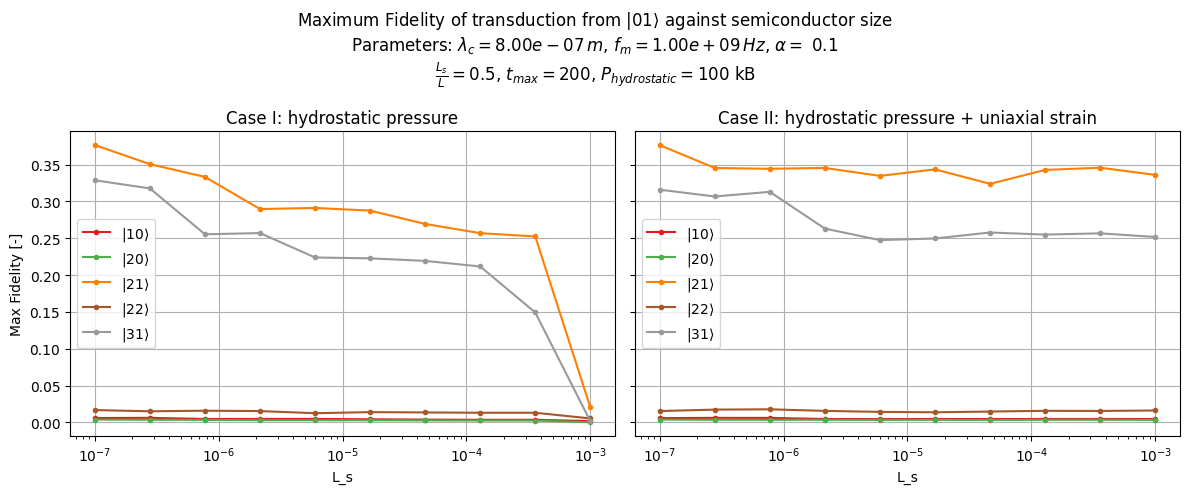

In [ ]:
alpha = 0.1
wavelength_photon = 0.8*1e-6 # m
frequency_phonon = 1e9 # Hz
tmax = 200

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega_phonon = 2*np.pi*frequency_phonon
cavity_semiconductor_length_factor = 2
omega_photon = 2*np.pi*3*10**8/wavelength_photon
expected_keys = ['10', '20', '21', '22', '31']
fidelity_dict_1st = {key: [] for key in expected_keys}
fidelity_dict_2nd = {key: [] for key in expected_keys}

lengths = np.logspace(-7, -3, 10)
for semiconductor_length in tqdm(lengths,total=len(lengths), desc='Progress'):
    omega_array, g_0_array_1st = compute_g0(outcar_name='PSTRESS/OUTCAR_100', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_semiconductor_length_factor*semiconductor_length, semiconductor_length= semiconductor_length)
    
    omega_array, g_0_array_2nd = compute_g0_2nd_approx(outcar_name='PSTRESS/OUTCAR_100', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_semiconductor_length_factor*semiconductor_length, semiconductor_length= semiconductor_length, 
        gradient_value=gradients[wavelength_photon])
    
    max_fidelities_1st, _ = compute_fidelity(omega_array, g_0_array_1st, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)
    
    max_fidelities_2nd, _ = compute_fidelity(omega_array, g_0_array_2nd, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)

    for key, value in max_fidelities_1st.items():
        fidelity_dict_1st[key].append(value)

    
    for key, value in max_fidelities_2nd.items():
        fidelity_dict_2nd[key].append(value)

# Assign a unique color to each key using a colormap
colors = plt.cm.Set1(np.linspace(0, 1, len(expected_keys)))  
color_map = {key: color for key, color in zip(expected_keys, colors)}
fig, ax = plt.subplots(1, 2, figsize=(12,5),sharey=True)
for key in expected_keys:
    ax[0].plot(lengths, fidelity_dict_1st[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])
    ax[1].plot(lengths, fidelity_dict_2nd[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel(r'L_s')
ax[1].set_xlabel(r'L_s')
ax[0].set_ylabel('Max Fidelity [-]')
ax[0].set_title('Case I: hydrostatic pressure')
ax[1].set_title('Case II: hydrostatic pressure + uniaxial strain')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(
    r'Maximum Fidelity of transduction from $\vert 01 \rangle$ against semiconductor size' '\n' +
    rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' +
    rf'$f_m = {frequency_phonon:.2e} \, Hz$, $\alpha =$ {alpha}' '\n' +
    r'$\frac{L_s}{L} = $' f'{1/cavity_semiconductor_length_factor}, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB',
    fontsize=12
)
plt.tight_layout()
plt.show()

### Fidelity against fraction of semiconductor in a cavity

Progress: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


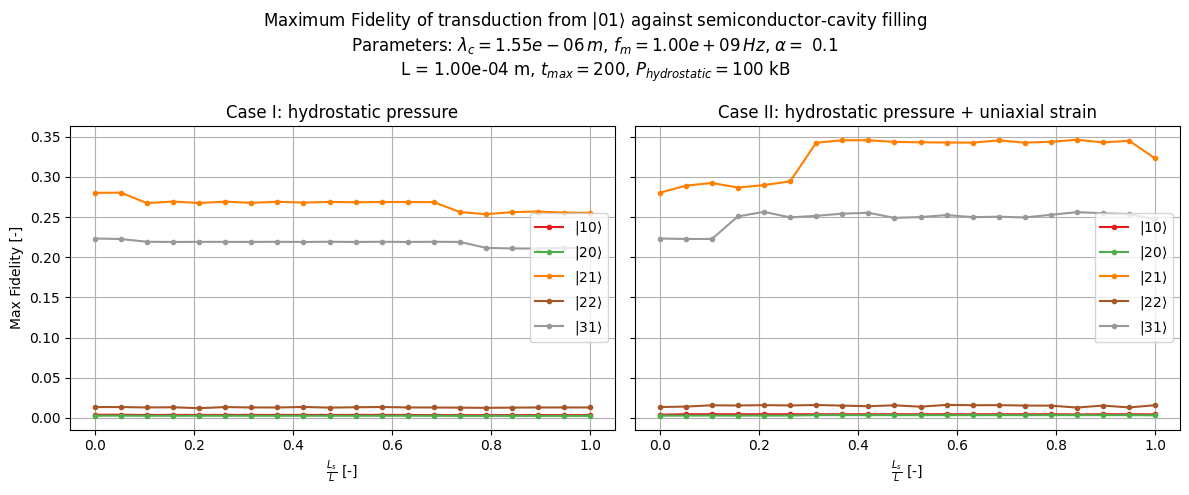

In [ ]:
alpha = 0.1
wavelength_photon = 1.55*1e-6 # m
frequency_phonon = 1e9 # Hz
tmax = 200
cavity_length = 1e-4 # m

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega_phonon = 2*np.pi*frequency_phonon
omega_photon = 2*np.pi*3*10**8/wavelength_photon
expected_keys = ['10', '20', '21', '22', '31']
fidelity_dict_1st = {key: [] for key in expected_keys}
fidelity_dict_2nd = {key: [] for key in expected_keys}

length_factors = np.linspace(0, 1, 20)
for factor in tqdm(length_factors,total=len(length_factors), desc='Progress'):
    omega_array, g_0_array_1st = compute_g0(outcar_name='PSTRESS/OUTCAR_100', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_length, semiconductor_length= cavity_length*factor)
    
    omega_array, g_0_array_2nd = compute_g0_2nd_approx(outcar_name='PSTRESS/OUTCAR_100', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_length, semiconductor_length= cavity_length*factor, 
        gradient_value=gradients[wavelength_photon])
    
    max_fidelities_1st, _ = compute_fidelity(omega_array, g_0_array_1st, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)
    
    max_fidelities_2nd, _ = compute_fidelity(omega_array, g_0_array_2nd, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)

    for key, value in max_fidelities_1st.items():
        fidelity_dict_1st[key].append(value)

    
    for key, value in max_fidelities_2nd.items():
        fidelity_dict_2nd[key].append(value)

# Assign a unique color to each key using a colormap
colors = plt.cm.Set1(np.linspace(0, 1, len(expected_keys)))  
color_map = {key: color for key, color in zip(expected_keys, colors)}
fig, ax = plt.subplots(1, 2, figsize=(12,5),sharey=True)
for key in expected_keys:
    ax[0].plot(length_factors, fidelity_dict_1st[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])
    ax[1].plot(length_factors, fidelity_dict_2nd[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])

ax[0].set_xlabel(r'$\frac{L_s}{L}$ [-]')
ax[1].set_xlabel(r'$\frac{L_s}{L}$ [-]')
ax[0].set_ylabel('Max Fidelity [-]')
ax[0].set_title('Case I: hydrostatic pressure')
ax[1].set_title('Case II: hydrostatic pressure + uniaxial strain')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(
    r'Maximum Fidelity of transduction from $\vert 01 \rangle$ against semiconductor-cavity filling' '\n' +
    rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' +
    rf'$f_m = {frequency_phonon:.2e} \, Hz$, $\alpha =$ {alpha}' '\n' +
    rf'L = {cavity_length:.2e} m, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB',
    fontsize=12
)
plt.tight_layout()
plt.show()

### Fidelity against phonon frequency

Progress: 100%|██████████| 30/30 [00:59<00:00,  1.99s/it]


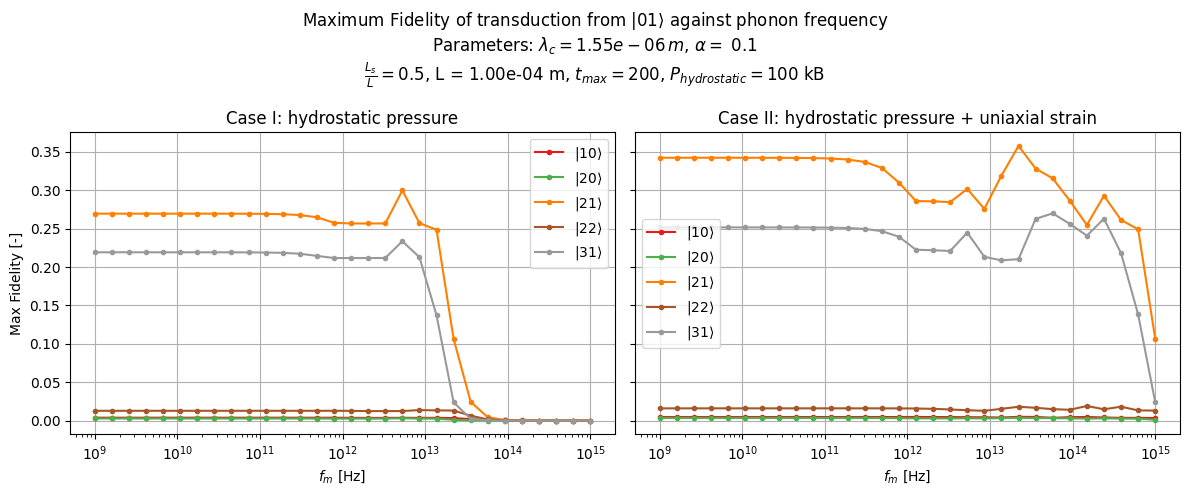

In [ ]:
alpha = 0.1
wavelength_photon = 1.55*1e-6 # m
frequency_phonon = 1e9 # Hz
tmax = 200
cavity_length = 1e-4 # m
cavity_semiconductor_length_factor = 2

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega_phonon = 2*np.pi*frequency_phonon
omega_photon = 2*np.pi*3*10**8/wavelength_photon
expected_keys = ['10', '20', '21', '22', '31']
fidelity_dict_1st = {key: [] for key in expected_keys}
fidelity_dict_2nd = {key: [] for key in expected_keys}

phonon_frequencies = 2*np.pi*np.logspace(9, 15, 30)
for omega_phonon in tqdm(phonon_frequencies,total=len(phonon_frequencies), desc='Progress'):
    omega_array, g_0_array_1st = compute_g0(outcar_name='PSTRESS/OUTCAR_100', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_length, semiconductor_length= cavity_length/cavity_semiconductor_length_factor)
    
    omega_array, g_0_array_2nd = compute_g0_2nd_approx(outcar_name='PSTRESS/OUTCAR_100', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_length, semiconductor_length= cavity_length/cavity_semiconductor_length_factor, 
        gradient_value=gradients[wavelength_photon])
    
    max_fidelities_1st, _ = compute_fidelity(omega_array, g_0_array_1st, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)
    
    max_fidelities_2nd, _ = compute_fidelity(omega_array, g_0_array_2nd, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)

    for key, value in max_fidelities_1st.items():
        fidelity_dict_1st[key].append(value)

    
    for key, value in max_fidelities_2nd.items():
        fidelity_dict_2nd[key].append(value)

# Assign a unique color to each key using a colormap
colors = plt.cm.Set1(np.linspace(0, 1, len(expected_keys)))  
color_map = {key: color for key, color in zip(expected_keys, colors)}
fig, ax = plt.subplots(1, 2, figsize=(12,5),sharey=True)
for key in expected_keys:
    ax[0].plot(phonon_frequencies/(2*np.pi), fidelity_dict_1st[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])
    ax[1].plot(phonon_frequencies/(2*np.pi), fidelity_dict_2nd[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel(r'$f_m$ [Hz]')
ax[1].set_xlabel(r'$f_m$ [Hz]')
ax[0].set_ylabel('Max Fidelity [-]')
ax[0].set_title('Case I: hydrostatic pressure')
ax[1].set_title('Case II: hydrostatic pressure + uniaxial strain')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(
    r'Maximum Fidelity of transduction from $\vert 01 \rangle$ against phonon frequency' '\n' +
    rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' rf'$\alpha =$ {alpha}' '\n' +
    r'$\frac{L_s}{L} = $' f'{1/cavity_semiconductor_length_factor}, '+
    rf'L = {cavity_length:.2e} m, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB',
    fontsize=12
)
plt.tight_layout()
plt.show()

### Fidelity against alpha

Progress: 100%|██████████| 20/20 [01:10<00:00,  3.50s/it]


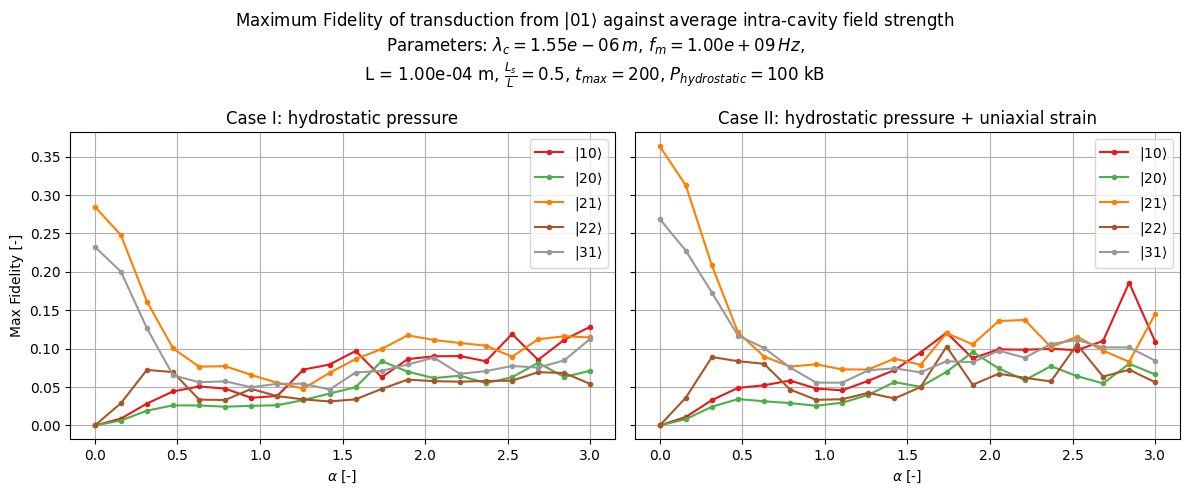

In [ ]:

wavelength_photon = 1.55*1e-6 # m
frequency_phonon = 1e9 # Hz
tmax = 200
cavity_length = 1e-4 # m
cavity_semiconductor_length_factor = 2

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega_phonon = 2*np.pi*frequency_phonon
omega_photon = 2*np.pi*3*10**8/wavelength_photon
expected_keys = ['10', '20', '21', '22', '31']
fidelity_dict_1st = {key: [] for key in expected_keys}
fidelity_dict_2nd = {key: [] for key in expected_keys}

# Extract g_0 using both approximations
omega_array, g_0_array_1st = compute_g0(outcar_name='PSTRESS/OUTCAR_100', 
    plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
    cavity_length= cavity_length, semiconductor_length= cavity_length/cavity_semiconductor_length_factor)

omega_array, g_0_array_2nd = compute_g0_2nd_approx(outcar_name='PSTRESS/OUTCAR_100', 
    plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
    cavity_length= cavity_length, semiconductor_length= cavity_length/cavity_semiconductor_length_factor, 
    gradient_value=gradients[wavelength_photon])

alpha_array = np.linspace(0,3,20)
for alpha in tqdm(alpha_array,total=len(alpha_array), desc='Progress'):
    
    max_fidelities_1st, _ = compute_fidelity(omega_array, g_0_array_1st, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)
    
    max_fidelities_2nd, _ = compute_fidelity(omega_array, g_0_array_2nd, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,plot_text=None,
                 plot = False, set_g_0 = None)

    for key, value in max_fidelities_1st.items():
        fidelity_dict_1st[key].append(value)

    
    for key, value in max_fidelities_2nd.items():
        fidelity_dict_2nd[key].append(value)

# Assign a unique color to each key using a colormap
colors = plt.cm.Set1(np.linspace(0, 1, len(expected_keys)))  
color_map = {key: color for key, color in zip(expected_keys, colors)}
fig, ax = plt.subplots(1, 2, figsize=(12,5),sharey=True)
for key in expected_keys:
    ax[0].plot(alpha_array, fidelity_dict_1st[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])
    ax[1].plot(alpha_array, fidelity_dict_2nd[key], label=rf'$\vert {key}\rangle$', marker='.', color=color_map[key])

ax[0].set_xlabel(r'$\alpha$ [-]')
ax[1].set_xlabel(r'$\alpha$ [-]')
ax[0].set_ylabel('Max Fidelity [-]')
ax[0].set_title('Case I: hydrostatic pressure')
ax[1].set_title('Case II: hydrostatic pressure + uniaxial strain')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(
    r'Maximum Fidelity of transduction from $\vert 01 \rangle$ against average intra-cavity field strength' '\n' +
    rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' +
    rf'$f_m = {frequency_phonon:.2e} \, Hz$,' '\n' +
    rf'L = {cavity_length:.2e} m, ' r'$\frac{L_s}{L} = $' f'{1/cavity_semiconductor_length_factor}, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB',
    fontsize=12
)

plt.tight_layout()
plt.show()

### Fidelity-time for realistic cavity

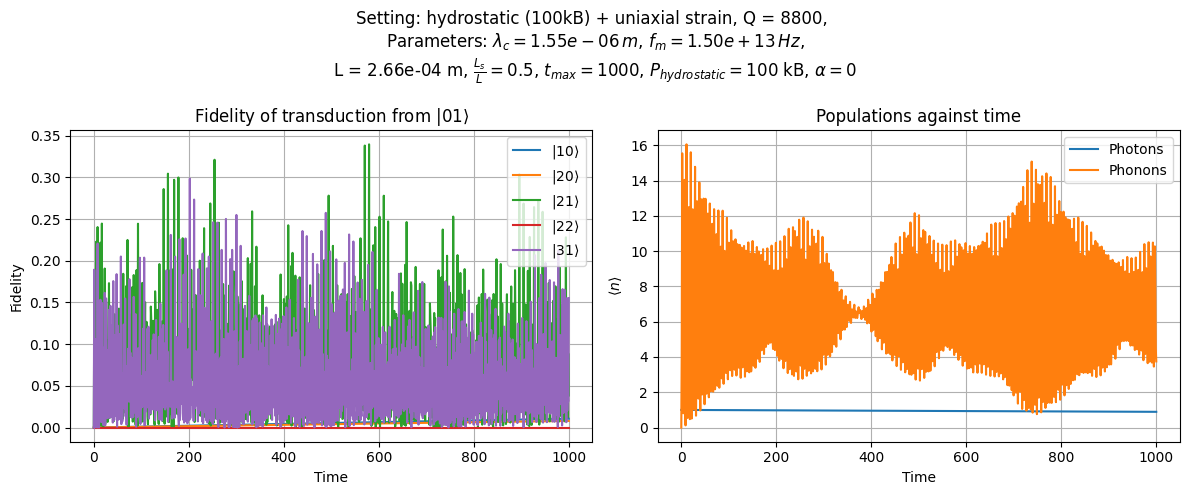

In [16]:
wavelength_photon = 1.55*10**-6
frequency_phonon = 15*10**12 
alpha = 0
cavity_length = 2.66*1e-4
semiconductor_length = cavity_length/2
Q = 8800
tmax = 1000

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega2, g_0_array_p2 = compute_g0_2nd_approx(outcar_name="PSTRESS/OUTCAR_100", 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_length, semiconductor_length= semiconductor_length, gradient_value=gradients[wavelength_photon])
max_fidelities, results = compute_fidelity(omega2, g_0_array_p2, alpha, omega_photon= 2*np.pi*3*10**8/wavelength_photon, 
                omega_phonon = 2*np.pi*frequency_phonon, photon_loss_rate= 1/Q, 
                truncation_photon_space = 3, truncation_phonon_space = 20, simulation_time= tmax, 
                 plot_text = f'Setting: hydrostatic (100kB) + uniaxial strain, Q = {Q}, \n' + 
                 rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' +
                        rf'$f_m = {frequency_phonon:.2e} \, Hz$,' '\n' +
    rf'L = {cavity_length:.2e} m, ' r'$\frac{L_s}{L} = $' f'{semiconductor_length/cavity_length}, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB, ' + rf'$\alpha = ${alpha}',
                 plot = True, set_g_0 = None)


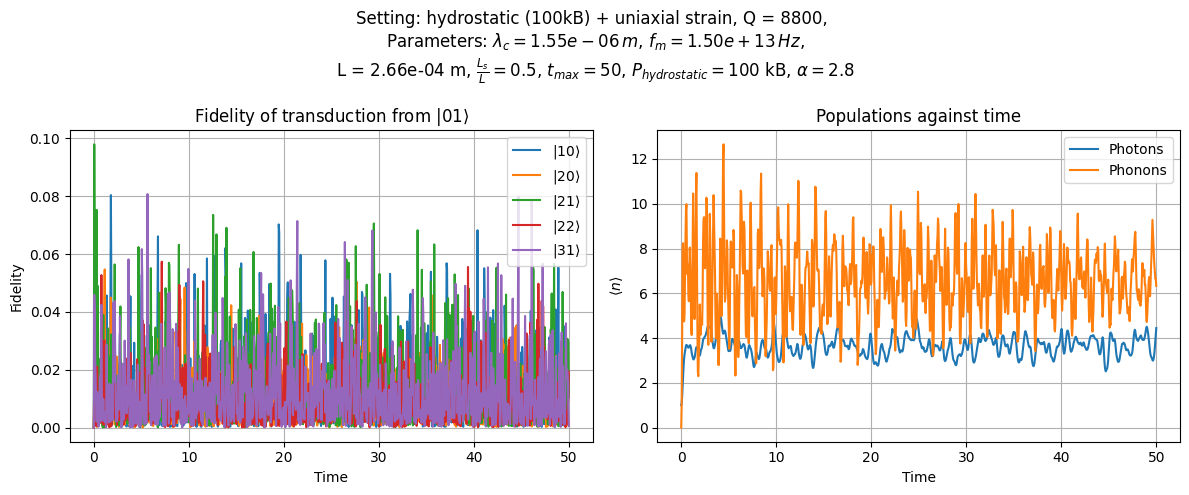

In [9]:
wavelength_photon = 1.55*10**-6
frequency_phonon = 15*10**12 
alpha = 2.8
cavity_length = 2.66*1e-4
semiconductor_length = cavity_length/2
Q = 8800
tmax = 50

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega2, g_0_array_p2 = compute_g0_2nd_approx(outcar_name="PSTRESS/OUTCAR_100", 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_length, semiconductor_length= semiconductor_length, gradient_value=gradients[wavelength_photon])
max_fidelities, results = compute_fidelity(omega2, g_0_array_p2, alpha, omega_photon= 2*np.pi*3*10**8/wavelength_photon, 
                omega_phonon = 2*np.pi*frequency_phonon, photon_loss_rate= 1/Q, 
                truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time= tmax, 
                 plot_text = f'Setting: hydrostatic (100kB) + uniaxial strain, Q = {Q}, \n' + 
                 rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' +
                        rf'$f_m = {frequency_phonon:.2e} \, Hz$,' '\n' +
    rf'L = {cavity_length:.2e} m, ' r'$\frac{L_s}{L} = $' f'{semiconductor_length/cavity_length}, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB, ' + rf'$\alpha = ${alpha}',
                 plot = True, set_g_0 = None)



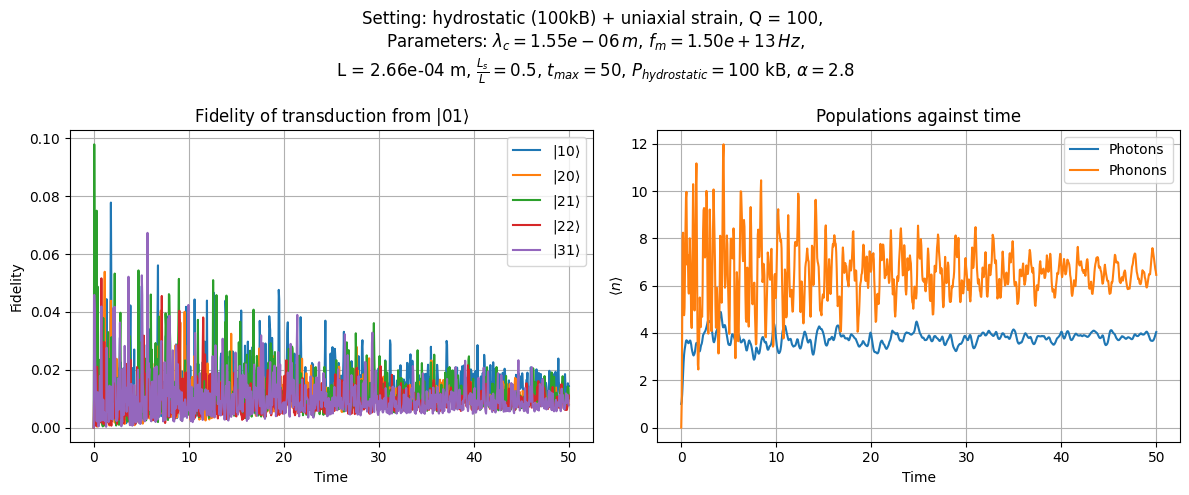

In [ ]:
wavelength_photon = 1.55*10**-6
frequency_phonon = 15*10**12 
alpha = 2.8
cavity_length = 2.66*1e-4
semiconductor_length = cavity_length/2
Q = 100
tmax = 50

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega2, g_0_array_p2 = compute_g0_2nd_approx(outcar_name="PSTRESS/OUTCAR_100", 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_length, semiconductor_length= semiconductor_length, gradient_value=gradients[wavelength_photon])
max_fidelities, results = compute_fidelity(omega2, g_0_array_p2, alpha, omega_photon= 2*np.pi*3*10**8/wavelength_photon, 
                omega_phonon = 2*np.pi*frequency_phonon, photon_loss_rate= 1/Q, 
                truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time= tmax, 
                 plot_text = f'Setting: hydrostatic (100kB) + uniaxial strain, Q = {Q}, \n' + 
                 rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' +
                        rf'$f_m = {frequency_phonon:.2e} \, Hz$,' '\n' +
    rf'L = {cavity_length:.2e} m, ' r'$\frac{L_s}{L} = $' f'{semiconductor_length/cavity_length}, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB, ' + rf'$\alpha = ${alpha}',
                 plot = True, set_g_0 = None)



### Fidelity-time for bad cavity

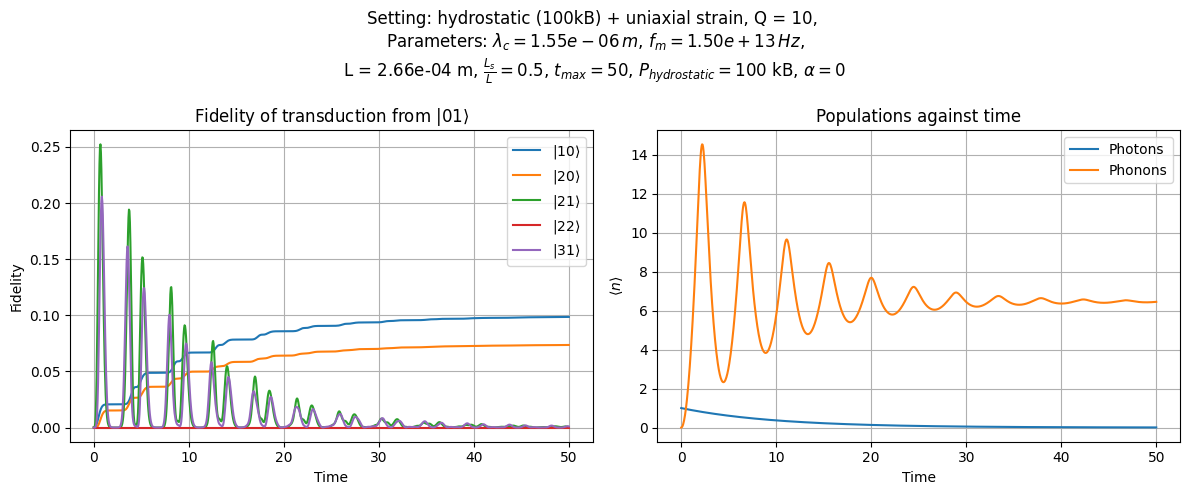

In [15]:
wavelength_photon = 1.55*10**-6
frequency_phonon = 15*10**12 
alpha = 0
cavity_length = 2.66*1e-4
semiconductor_length = cavity_length/2
Q = 10
tmax = 50

###
gradients = {1.55*1e-6: 2.1206073, 0.8*1e-6: 2.6928968}
omega2, g_0_array_p2 = compute_g0_2nd_approx(outcar_name="PSTRESS/OUTCAR_100", 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_length, semiconductor_length= semiconductor_length, gradient_value=gradients[wavelength_photon])
max_fidelities, results = compute_fidelity(omega2, g_0_array_p2, alpha, omega_photon= 2*np.pi*3*10**8/wavelength_photon, 
                omega_phonon = 2*np.pi*frequency_phonon, photon_loss_rate= 1/Q, 
                truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time= tmax, 
                 plot_text = f'Setting: hydrostatic (100kB) + uniaxial strain, Q = {Q}, \n' + 
                 rf'Parameters: $\lambda_c = {wavelength_photon:.2e} \, m$, ' +
                        rf'$f_m = {frequency_phonon:.2e} \, Hz$,' '\n' +
    rf'L = {cavity_length:.2e} m, ' r'$\frac{L_s}{L} = $' f'{semiconductor_length/cavity_length}, ' +
    r'$t_{max} = $' f'{tmax}, ' + r'$P_{hydrostatic} = 100$ kB, ' + rf'$\alpha = ${alpha}',
                 plot = True, set_g_0 = None)
